<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 301, '日付': '2021-03-05T08:00:00.000Z'},
 {'小計': 293, '日付': '2021-03-06T08:00:00.000Z'},
 {'小計': 237, '日付': '2021-03-07T08:00:00.000Z'},
 {'小計': 116, '日付': '2021-03-08T08:00:00.000Z'},
 {'小計': 290, '日付': '2021-03-09T08:00:00.000Z'},
 {'小計': 340, '日付': '2021-03-10T08:00:00.000Z'},
 {'小計': 335, '日付': '2021-03-11T08:00:00.000Z'},
 {'小計': 304, '日付': '2021-03-12T08:00:00.000Z'},
 {'小計': 330, '日付': '2021-03-13T08:00:00.000Z'},
 {'小計': 239, '日付': '2021-03-14T08:00:00.000Z'},
 {'小計': 175, '日付': '2021-03-15T08:00:00.000Z'},
 {'小計': 300, '日付': '2021-03-16T08:00:00.000Z'},
 {'小計': 409, '日付': '2021-03-17T08:00:00.000Z'},
 {'小計': 323, '日付': '2021-03-18T08:00:00.000Z'},
 {'小計': 303, '日付': '2021-03-19T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-03-15 17:00:00+09:00,269,0,175,2021-03-15 17:00:00+09:00
2021-03-16 17:00:00+09:00,228,0,300,2021-03-16 17:00:00+09:00
2021-03-17 17:00:00+09:00,249,0,409,2021-03-17 17:00:00+09:00
2021-03-18 17:00:00+09:00,264,0,323,2021-03-18 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-03-15 17:00:00+09:00,269,0,175,2021-03-15 17:00:00+09:00,234.000000,1638.0,0.0,0.0,287.571429,2013.0
2021-03-16 17:00:00+09:00,228,0,300,2021-03-16 17:00:00+09:00,232.285714,1626.0,0.0,0.0,289.000000,2023.0
2021-03-17 17:00:00+09:00,249,0,409,2021-03-17 17:00:00+09:00,233.428571,1634.0,0.0,0.0,298.857143,2092.0
2021-03-18 17:00:00+09:00,264,0,323,2021-03-18 17:00:00+09:00,239.857143,1679.0,0.0,0.0,297.142857,2080.0
2021-03-19 17:00:00+09:00,0,0,303,2021-03-19 17:00:00+09:00,209.857143,1469.0,0.0,0.0,297.000000,2079.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-03-05 17:00:00+09:00,246,0,301,2021-03-05 17:00:00+09:00,237.571429,1663.0,0.0,0.0,273.571429,1915.0,'21w09,Fri
2021-03-06 17:00:00+09:00,243,0,293,2021-03-06 17:00:00+09:00,229.857143,1609.0,0.0,0.0,267.285714,1871.0,'21w09,Sat
2021-03-07 17:00:00+09:00,192,0,237,2021-03-07 17:00:00+09:00,227.142857,1590.0,0.0,0.0,254.142857,1779.0,'21w09,Sun
2021-03-08 17:00:00+09:00,277,0,116,2021-03-08 17:00:00+09:00,228.714286,1601.0,0.0,0.0,253.428571,1774.0,'21w10,Mon
2021-03-09 17:00:00+09:00,240,0,290,2021-03-09 17:00:00+09:00,233.000000,1631.0,0.0,0.0,261.714286,1832.0,'21w10,Tue
2021-03-10 17:00:00+09:00,241,0,340,2021-03-10 17:00:00+09:00,238.714286,1671.0,0.0,0.0,265.142857,1856.0,'21w10,Wed
2021-03-11 17:00:00+09:00,219,0,335,2021-03-11 17:00:00+09:00,236.857143,1658.0,0.0,0.0,273.142857,1912.0,'21w10,Thu
2021-03-12 17:00:00+09:00,210,0,304,2021-03-12 17:00:00+09:00,231.714286,1622.0,0.0,0.0,273.571429,1915.0,'21w10,Fri
2021-03-13 17:00:00+09:00,235,0,330,2021-03-13 17:00:00+09:00,230.571429,1614.0,0.0,0.0,278.857143,1952.0,'21w10,Sat
2021-03-14 17:00:00+09:00,224,0,239,2021-03-14 17:00:00+09:00,235.142857,1646.0,0.0,0.0,279.142857,1954.0,'21w10,Sun


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-02-28 17:00:00+09:00,277.428571,1942
2021-03-07 17:00:00+09:00,254.142857,1779
2021-03-14 17:00:00+09:00,279.142857,1954
2021-03-19 17:00:00+09:00,302.000000,1510
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-03-05 17:00:00+09:00,246,0,301,2021-03-05 17:00:00+09:00,237.571429,1663.0,0.0,0.0,273.571429,1915.0,'21w09,Fri,NaN,NaN
2021-03-06 17:00:00+09:00,243,0,293,2021-03-06 17:00:00+09:00,229.857143,1609.0,0.0,0.0,267.285714,1871.0,'21w09,Sat,NaN,NaN
2021-03-07 17:00:00+09:00,192,0,237,2021-03-07 17:00:00+09:00,227.142857,1590.0,0.0,0.0,254.142857,1779.0,'21w09,Sun,254.142857,1779.0
2021-03-08 17:00:00+09:00,277,0,116,2021-03-08 17:00:00+09:00,228.714286,1601.0,0.0,0.0,253.428571,1774.0,'21w10,Mon,NaN,NaN
2021-03-09 17:00:00+09:00,240,0,290,2021-03-09 17:00:00+09:00,233.000000,1631.0,0.0,0.0,261.714286,1832.0,'21w10,Tue,NaN,NaN
2021-03-10 17:00:00+09:00,241,0,340,2021-03-10 17:00:00+09:00,238.714286,1671.0,0.0,0.0,265.142857,1856.0,'21w10,Wed,NaN,NaN
2021-03-11 17:00:00+09:00,219,0,335,2021-03-11 17:00:00+09:00,236.857143,1658.0,0.0,0.0,273.142857,1912.0,'21w10,Thu,NaN,NaN
2021-03-12 17:00:00+09:00,210,0,304,2021-03-12 17:00:00+09:00,231.714286,1622.0,0.0,0.0,273.571429,1915.0,'21w10,Fri,NaN,NaN
2021-03-13 17:00:00+09:00,235,0,330,2021-03-13 17:00:00+09:00,230.571429,1614.0,0.0,0.0,278.857143,1952.0,'21w10,Sat,NaN,NaN
2021-03-14 17:00:00+09:00,224,0,239,2021-03-14 17:00:00+09:00,235.142857,1646.0,0.0,0.0,279.142857,1954.0,'21w10,Sun,279.142857,1954.0


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

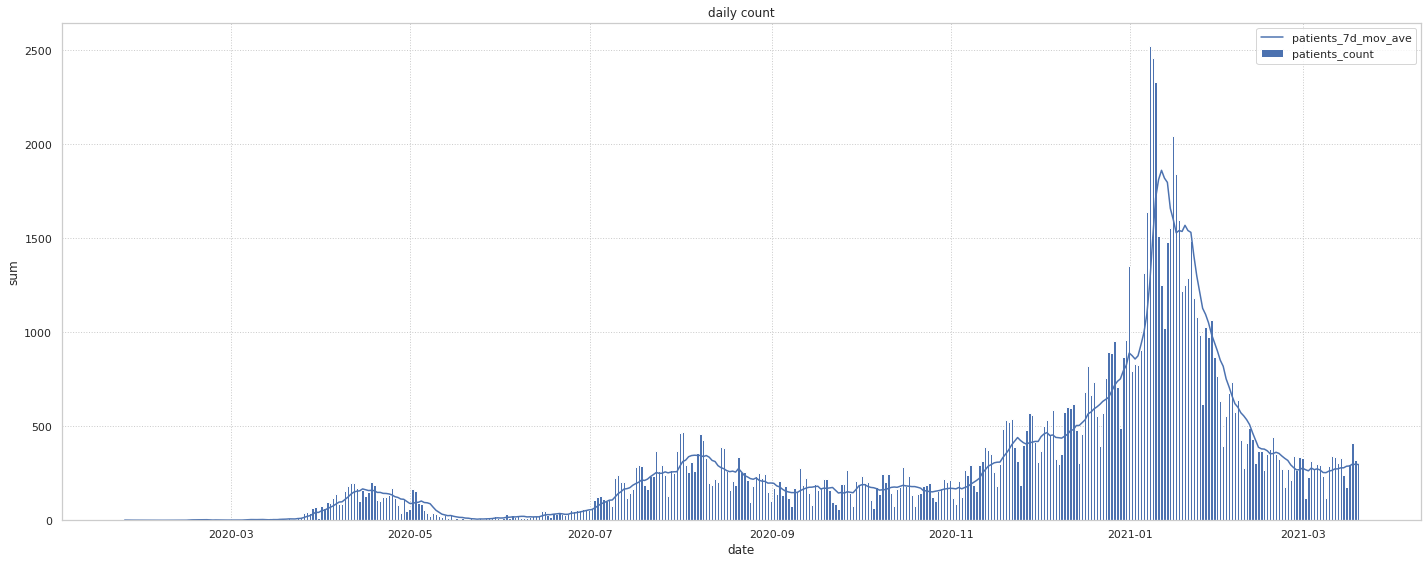

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
406,1.614931e+09,2021,3,5,1,0,0,0,0,0,0,406,0,332,246,237.571429,1663.0,0,0.0,0.0,301,273.571429,1915.0
407,1.615018e+09,2021,3,6,0,0,1,0,0,0,0,407,0,333,243,229.857143,1609.0,0,0.0,0.0,293,267.285714,1871.0
408,1.615104e+09,2021,3,7,0,0,0,1,0,0,0,408,0,334,192,227.142857,1590.0,0,0.0,0.0,237,254.142857,1779.0
409,1.615190e+09,2021,3,8,0,1,0,0,0,0,0,409,0,335,277,228.714286,1601.0,0,0.0,0.0,116,253.428571,1774.0
410,1.615277e+09,2021,3,9,0,0,0,0,0,1,0,410,0,336,240,233.000000,1631.0,0,0.0,0.0,290,261.714286,1832.0
411,1.615363e+09,2021,3,10,0,0,0,0,0,0,1,411,0,337,241,238.714286,1671.0,0,0.0,0.0,340,265.142857,1856.0
412,1.615450e+09,2021,3,11,0,0,0,0,1,0,0,412,0,338,219,236.857143,1658.0,0,0.0,0.0,335,273.142857,1912.0
413,1.615536e+09,2021,3,12,1,0,0,0,0,0,0,413,0,339,210,231.714286,1622.0,0,0.0,0.0,304,273.571429,1915.0
414,1.615622e+09,2021,3,13,0,0,1,0,0,0,0,414,0,340,235,230.571429,1614.0,0,0.0,0.0,330,278.857143,1952.0
415,1.615709e+09,2021,3,14,0,0,0,1,0,0,0,415,0,341,224,235.142857,1646.0,0,0.0,0.0,239,279.142857,1954.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            421 non-null    float64
 1   year                 421 non-null    int64  
 2   month                421 non-null    int64  
 3   day                  421 non-null    int64  
 4   Fri                  421 non-null    uint8  
 5   Mon                  421 non-null    uint8  
 6   Sat                  421 non-null    uint8  
 7   Sun                  421 non-null    uint8  
 8   Thu                  421 non-null    uint8  
 9   Tue                  421 non-null    uint8  
 10  Wed                  421 non-null    uint8  
 11  passed               421 non-null    int64  
 12  emergency            421 non-null    int64  
 13  em_passed            421 non-null    int64  
 14  contacts_count       421 non-null    int64  
 15  contacts_7d_mov_ave  421 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.210000e+02,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000,421.000000
mean,1.597997e+09,2020.185273,5.950119,15.636580,0.144893,0.142518,0.142518,0.142518,0.142518,0.142518,0.142518,210.000000,0.116390,142.591449,705.399050,704.123798,4928.857482,875.342043,875.342043,6127.394299,277.717340,275.497557,1928.444181
std,1.051285e+07,0.388981,3.543590,8.813868,0.352412,0.349996,0.349996,0.349996,0.349996,0.349996,0.349996,121.676484,0.321073,112.411380,461.519238,447.651146,3133.572306,882.372355,776.059363,5432.415542,373.149425,353.945500,2477.648650
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.588925e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,31.000000,401.000000,406.000000,2842.000000,0.000000,0.000000,0.000000,37.000000,32.714286,229.000000
50%,1.597997e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,210.000000,0.000000,136.000000,568.000000,580.142857,4061.000000,801.000000,993.428571,6954.000000,177.000000,171.428571,1200.000000
75%,1.607069e+09,2020.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,315.000000,0.000000,241.000000,867.000000,885.000000,6195.000000,1466.000000,1444.428571,10111.000000,329.000000,320.000000,2240.000000
max,1.616141e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,420.000000,1.000000,346.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.672937,0.241270,-0.026344,-7.182262e-18,-0.001677,-0.008386,-0.005032,0.008386,0.001677,0.005032,1.000000,-0.334468,0.992734,-0.223268,-0.196234,-0.196228,-0.415199,-0.444202,-0.444202,0.604768,0.645928,0.645947
year,6.729366e-01,1.000000,-0.552938,-0.088652,1.212933e-02,-0.002036,-0.002036,-0.002036,-0.002036,-0.002036,-0.002036,0.672937,-0.173072,0.700405,-0.200109,-0.162801,-0.162799,-0.473634,-0.538517,-0.538517,0.573225,0.641127,0.641126
month,2.412696e-01,-0.552938,1.000000,0.005212,-1.707777e-02,0.001906,-0.007693,-0.003853,0.011505,0.005746,0.009585,0.241270,-0.147651,0.196592,0.013533,-0.005334,-0.005330,0.156059,0.210328,0.210328,-0.074553,-0.118688,-0.118664
day,-2.634401e-02,-0.088652,0.005212,1.000000,1.392696e-02,-0.013271,0.009883,0.009883,0.008340,-0.014043,-0.014815,-0.026344,0.002362,-0.025741,-0.000457,0.001914,0.001910,0.022172,0.006383,0.006383,-0.009041,0.001422,0.001405
Fri,-7.182262e-18,0.012129,-0.017078,0.013927,1.000000e+00,-0.167817,-0.167817,-0.167817,-0.167817,-0.167817,-0.167817,0.000000,-0.002099,0.001618,-0.026999,-0.007951,-0.007950,0.036034,-0.006532,-0.006532,0.048347,-0.001943,-0.001953
Mon,-1.677265e-03,-0.002036,0.001906,-0.013271,-1.678169e-01,1.000000,-0.166205,-0.166205,-0.166205,-0.166205,-0.166205,-0.001677,0.000352,-0.001784,0.042924,0.001085,0.001087,0.167296,0.001096,0.001096,-0.108984,-0.000339,-0.000337
Sat,-8.386327e-03,-0.002036,-0.007693,0.009883,-1.678169e-01,-0.166205,1.000000,-0.166205,-0.166205,-0.166205,-0.166205,-0.008386,0.000352,-0.007715,0.049571,0.000015,0.000016,-0.191034,0.001096,0.001096,0.053160,-0.001466,-0.001473
Sun,-5.031796e-03,-0.002036,-0.003853,0.009883,-1.678169e-01,-0.166205,-0.166205,1.000000,-0.166205,-0.166205,-0.166205,-0.005032,0.000352,-0.004750,-0.014518,0.000501,0.000503,-0.175931,0.001096,0.001096,-0.033618,-0.000816,-0.000817
Thu,8.386327e-03,-0.002036,0.011505,0.008340,-1.678169e-01,-0.166205,-0.166205,-0.166205,1.000000,-0.166205,-0.166205,0.008386,0.000352,0.007233,-0.010391,0.002694,0.002695,0.049492,0.001096,0.001096,0.075876,0.002490,0.002497
Tue,1.677265e-03,-0.002036,0.005746,-0.014043,-1.678169e-01,-0.166205,-0.166205,-0.166205,-0.166205,1.000000,-0.166205,0.001677,0.000352,0.001181,-0.024571,0.001580,0.001582,0.067324,0.001096,0.001096,-0.037556,0.000483,0.000487


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,1.615795e+09,0,1,0,0,0,0,0,416,0,342,269,0,175,287.571429,2013.0
417,1.615882e+09,0,0,0,0,0,1,0,417,0,343,228,0,300,289.000000,2023.0
418,1.615968e+09,0,0,0,0,0,0,1,418,0,344,249,0,409,298.857143,2092.0
419,1.616054e+09,0,0,0,0,1,0,0,419,0,345,264,0,323,297.142857,2080.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
416,1.615795e+09,416,0,175,287.571429,2013.0
417,1.615882e+09,417,0,300,289.000000,2023.0
418,1.615968e+09,418,0,409,298.857143,2092.0
419,1.616054e+09,419,0,323,297.142857,2080.0


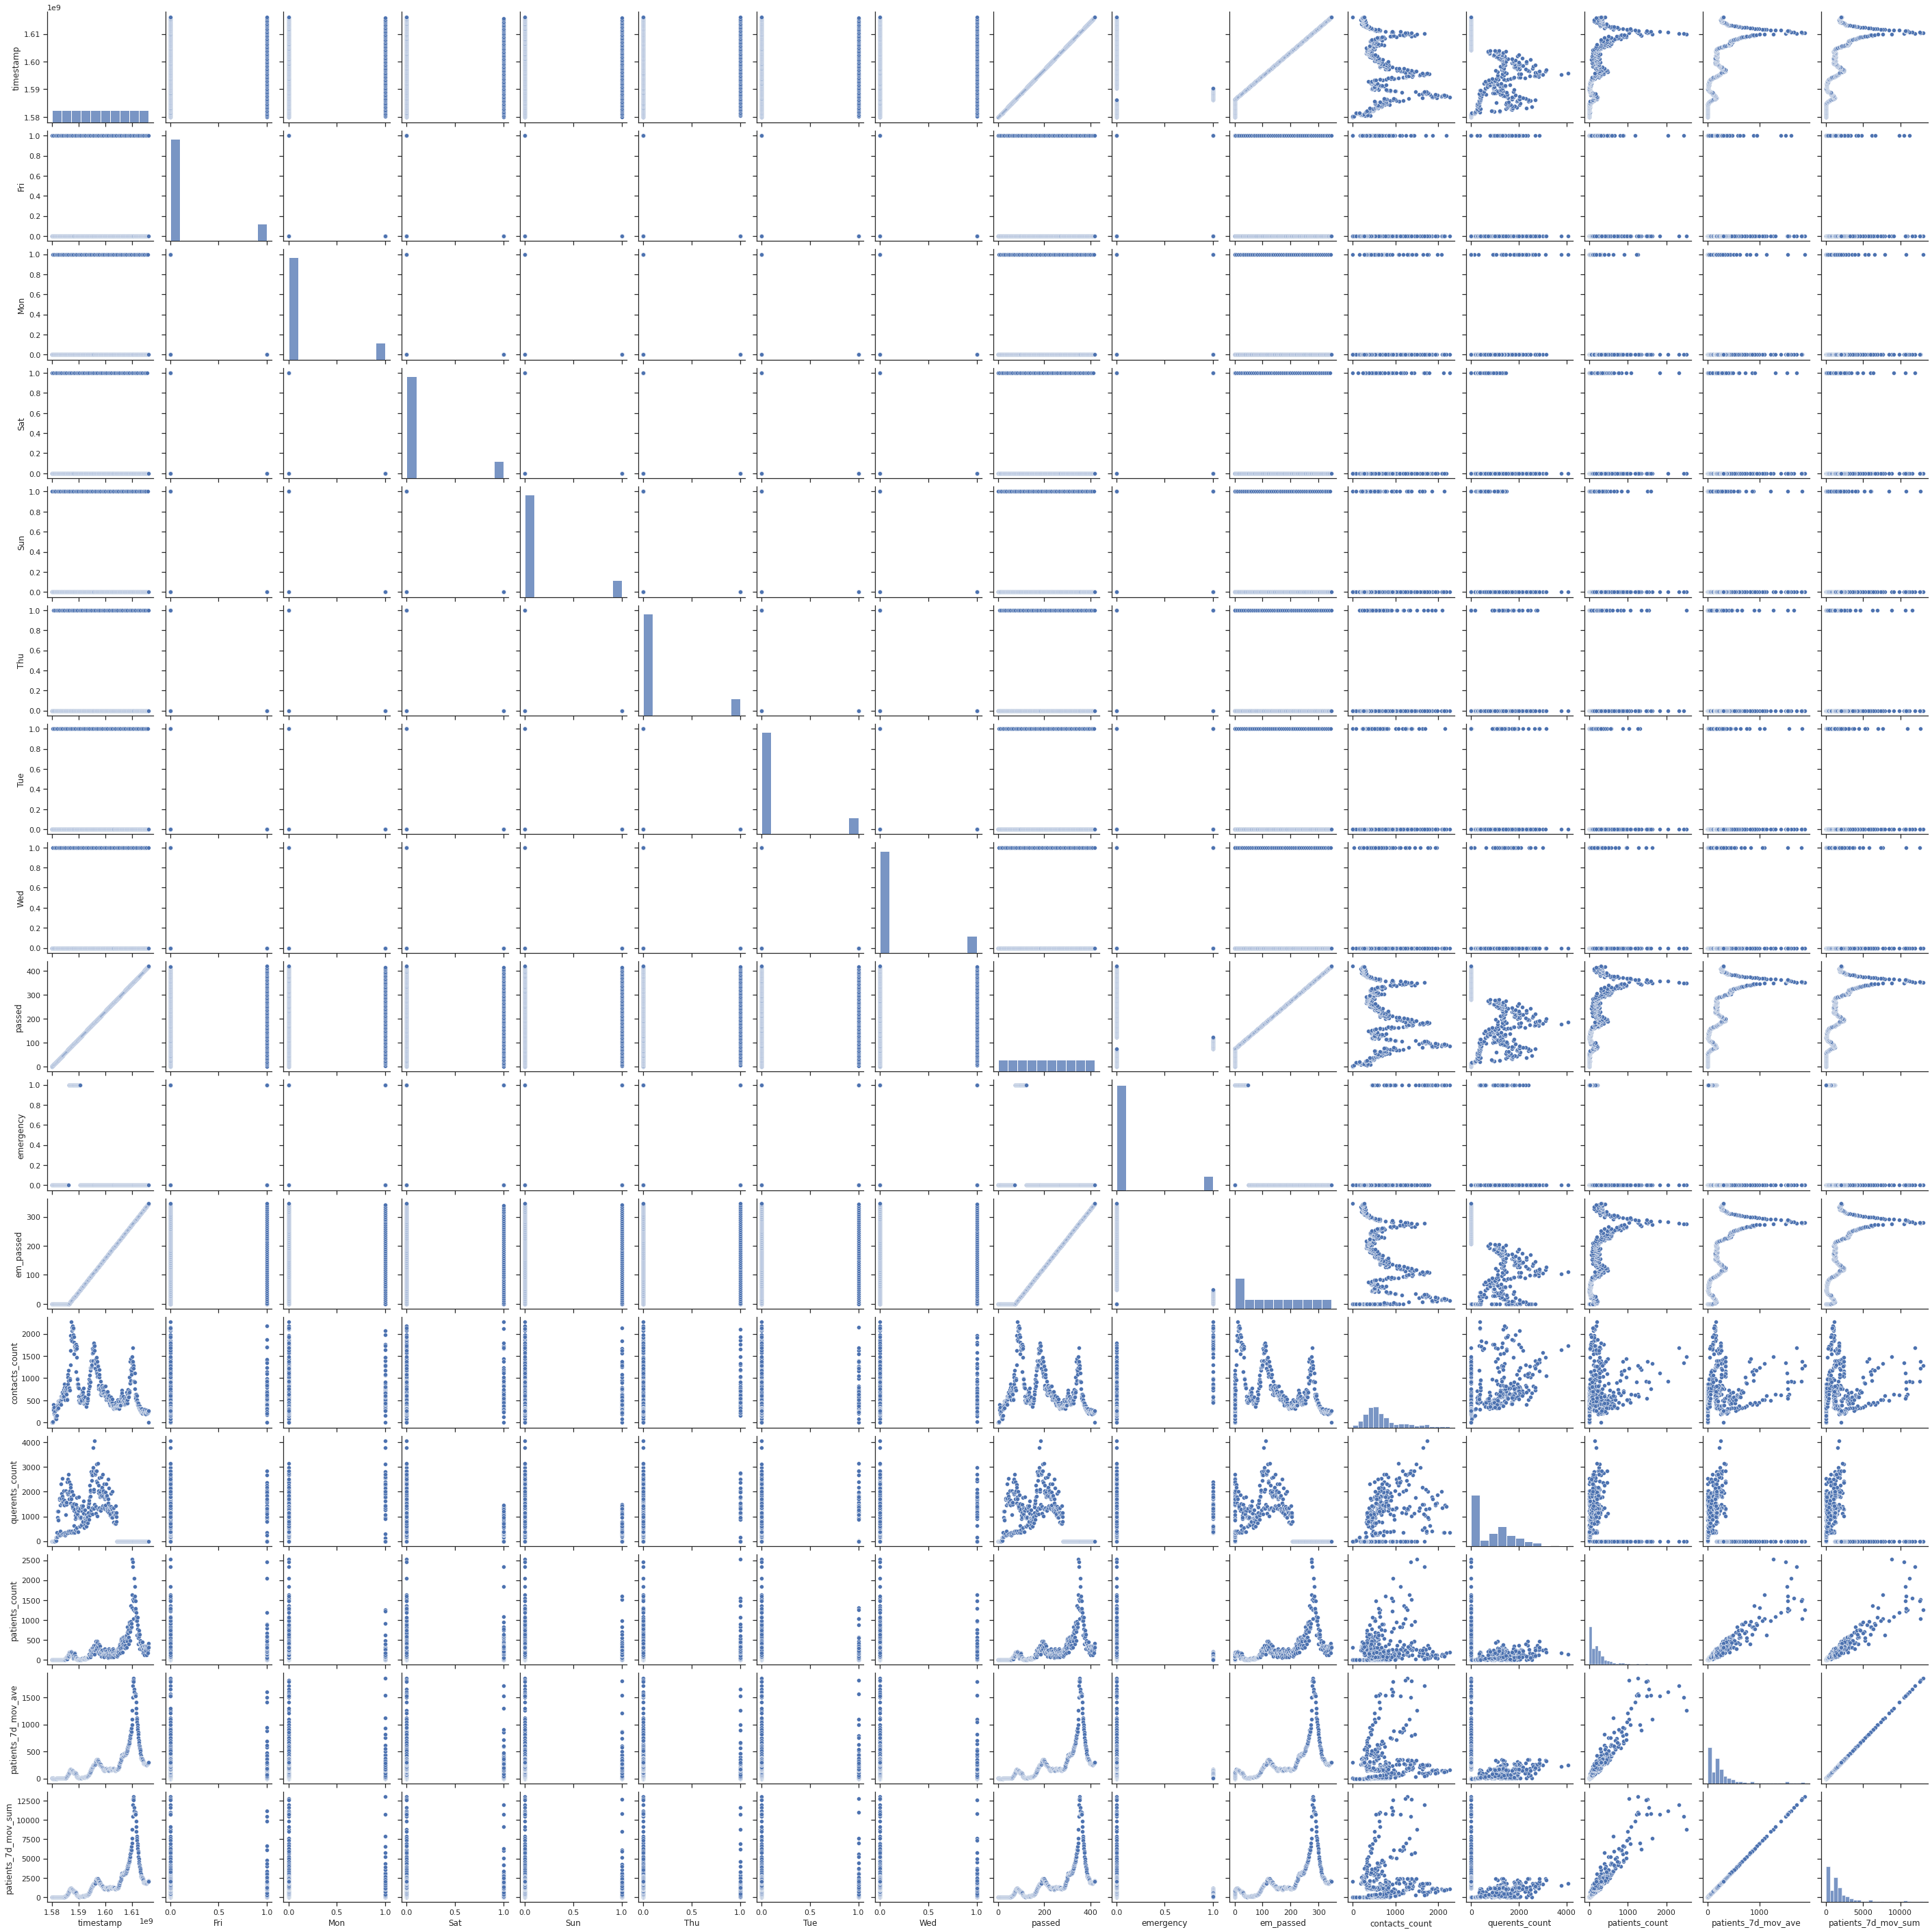

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

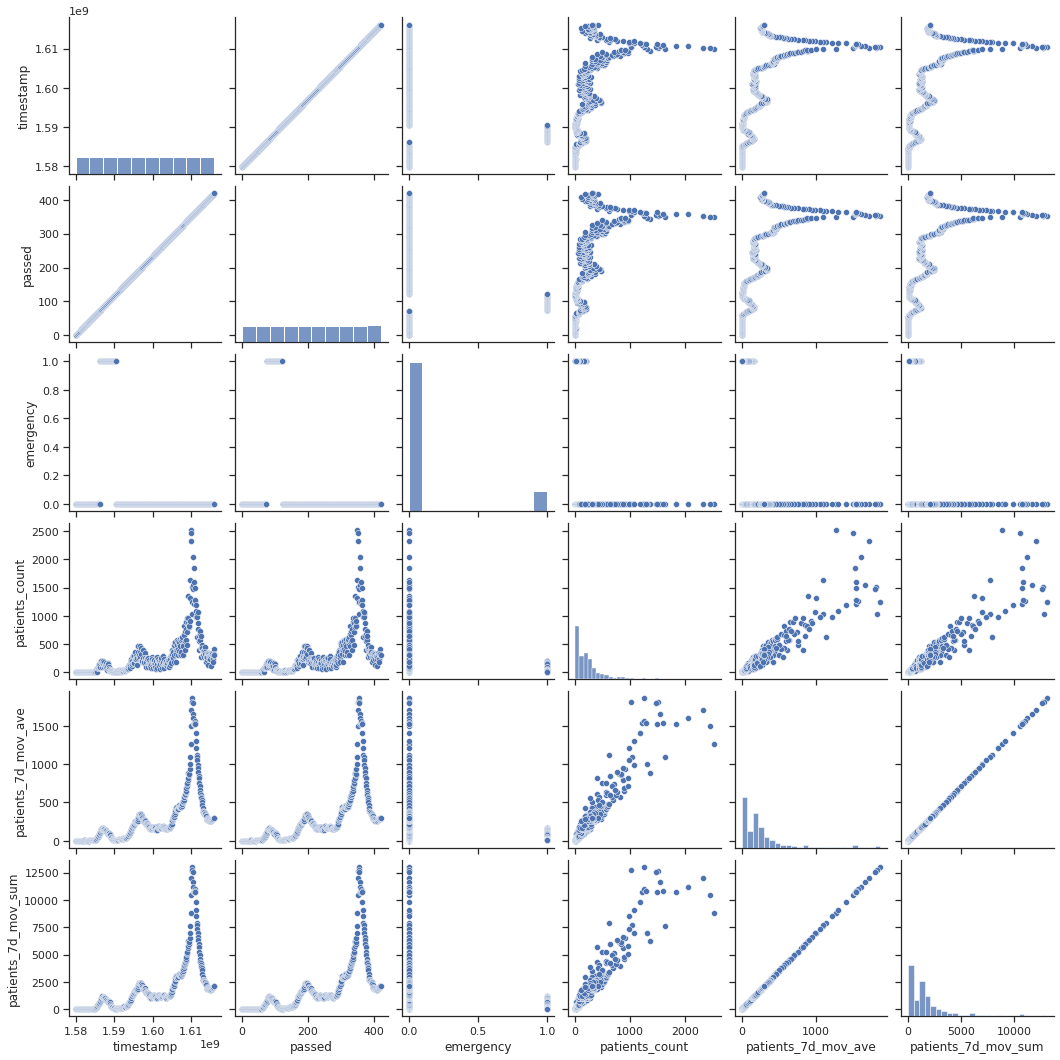

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
